In [147]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [148]:
from typing import Annotated, TypedDict, Optional
from datetime import datetime
from pydantic import Field, BaseModel, ValidationError
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# class Employee(BaseModel):
#     name: Annotated[str, "사용자 이름"]
#     date: Annotated[int, "휴가 시작일"]
#     type: Annotated[str, "휴가 종류"]
#     reason: Annotated[str, "휴가 사유"]


class State(TypedDict):
    question: Annotated[str, "Question"]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages]
    need_date: Annotated[bool, "Whether to request a date"]
    need_time: Annotated[bool, "Whether to request current time"]  # 시간 요청 여부

In [ ]:
# ✅ 날짜 및 시간을 context에 추가하는 함수
def update_context(state: State):
    today = datetime.today().strftime("%Y-%m-%d")
    current_time = datetime.now().strftime("%H:%M:%S")

    # `context`가 비어 있으면 초기값 설정
    if not state.get("context"):
        state["context"] = ""

    # 오늘 날짜와 현재 시간을 context에 추가
    state["context"] += f" 오늘 날짜는 {today}이며, 현재 시간은 {current_time}입니다."

    return {"next": "response_bot"}


# ✅ 첫 번째 챗봇: context 업데이트 후 응답 생성으로 이동
def chatbot(state: State):
    return {"next": "update_context"}


# ✅ 응답 생성 챗봇: 모델이 context를 참고하여 자연스럽게 날짜를 해석하도록 함
def response_bot(state: State):
    """
    context를 참고하여 모델이 답변을 생성
    """
    answer = f"참고할 정보: {state.get('context', '')}. 사용자 질문에 대한 답변입니다."
    state["answer"] = answer

    return {
        "messages": [{"role": "assistant", "content": answer}],
        "next": END,  # 종료
    }

In [154]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)  # 질문 분석 챗봇
graph_builder.add_node("update_context", update_context)  # 날짜/시간 정보 추가
graph_builder.add_node("response_bot", response_bot)  # 최종 응답 생성 챗봇

graph_builder.add_edge(START, "chatbot")

# 노드 연결: chatbot -> context 업데이트 -> 응답 생성
graph_builder.add_edge("chatbot", "update_context")
graph_builder.add_edge("update_context", "response_bot")

# 응답 생성 후 종료
graph_builder.add_edge("response_bot", END)

# 그래프 컴파일
graph = graph_builder.compile()

In [155]:
question = "다음주 수요일은 언제야?"

for event in graph.stream(
    {"question": question, "context": "", "messages": [], "answer": ""}
):
    for value in event.values():
        if value and isinstance(value, dict) and "messages" in value:
            last_message = value["messages"][-1]

            if isinstance(last_message, dict) and "content" in last_message:
                print("Assistant:", last_message["content"])
            else:
                print("Warning: Last message does not have 'content'")
        else:
            print("Warning: No valid response received from the model.")

Assistant: 참고할 정보: . 사용자 질문에 대한 답변입니다.


In [ ]:
from langchain.tools import Tool

# 도구 인스턴스 생성
date_tool = GetCurrentDateTime()


def get_today_date_wrapper(state: State):
    state["need_date"] = False  # 호출 후 need_date 비활성화
    state["context"] = datetime.today().strftime("%Y-%m-%d")

    return {"date": datetime.today().strftime("%Y-%m-%d")}  # dict 반환


def get_current_time_wrapper(state: State):
    return {"time": datetime.now().strftime("%H:%M:%S")}  # dict 반환


# OpenAI Tool 형식에 맞게 변환
get_today_date_tool = Tool(
    name="get_today_date",
    func=get_today_date_wrapper,  # 수정된 함수 적용
    description="현재 날짜를 반환하는 도구",
)

get_current_time_tool = Tool(
    name="get_current_time",
    func=get_current_time_wrapper,  # 수정된 함수 적용
    description="현재 시간을 반환하는 도구",
)

# 도구 목록에 추가 (클래스 인스턴스가 아닌, Tool 객체 추가)
tools = [get_today_date_tool, get_current_time_tool]

In [140]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4", temperature=0)

# OpenAI Tool API에 맞게 바인딩
llm_with_tool = llm.bind_tools(tools)


def chatbot(state: State):
    """
    사용자의 입력을 분석하여 필요한 정보를 판단하는 챗봇
    """
    user_message = state.get("messages", [])

    # 마지막 사용자 메시지가 dict인지 확인
    if isinstance(user_message[-1], dict):
        user_text = user_message[-1]["content"]
    else:
        user_text = user_message[-1].content

    # 날짜 또는 시간 요청 판단 후 need_time 또는 need_date 활성화
    if "시간" in user_text:
        if "time" in state:  # 이미 저장된 경우 바로 응답 생성
            return {"next": "response_bot"}
        state["need_time"] = True  # 필요 시 need_time 활성화
        return {"next": "get_current_time"}

    elif "날짜" in user_text:
        if "date" in state:  # 이미 저장된 경우 바로 응답 생성
            return {"next": "response_bot"}
        state["need_date"] = True  # 필요 시 need_date 활성화
        return {"next": "get_today_date"}

    # 아무 것도 해당되지 않으면 응답 생성으로 이동
    return {"next": "response_bot"}


def response_bot(state: State):
    """
    시간 또는 날짜 정보를 확인하고 최종 응답을 생성하는 챗봇
    """
    assistant_response = "제가 도와드릴 수 있는 정보를 알려주세요."

    if state.get("time"):
        assistant_response = f"현재 시간은 {state['time']}입니다."
    elif state.get("date"):
        assistant_response = f"오늘 날짜는 {state['date']}입니다."

    return {
        "messages": [{"role": "assistant", "content": assistant_response}],
        "next": END,  # 종료로 이동
    }

In [141]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)  # 입력 분석 챗봇
graph_builder.add_node("get_today_date", GetCurrentDateTime.get_today_date)  # 날짜 도구
graph_builder.add_node(
    "get_current_time", GetCurrentDateTime.get_current_time
)  # 시간 도구
graph_builder.add_node("response_bot", response_bot)  # 응답 생성 챗봇

In [142]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

# 노드 연결: 챗봇 -> 필요 정보 판단
graph_builder.add_edge("chatbot", "get_today_date")
graph_builder.add_edge("chatbot", "get_current_time")
graph_builder.add_edge("chatbot", "response_bot")

# 날짜 또는 시간 조회 후 응답 생성으로 이동
graph_builder.add_edge("get_today_date", "response_bot")
graph_builder.add_edge("get_current_time", "response_bot")

# 응답 생성 후 종료
graph_builder.add_edge("response_bot", END)

# 그래프 컴파일
graph = graph_builder.compile()

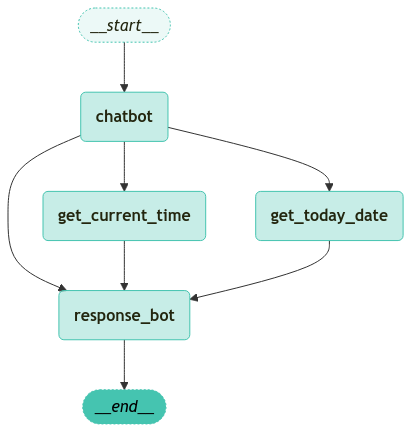

In [143]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [ ]:
question = "오늘 날짜를 알려줘"

for event in graph.stream({"messages": [("user", question)]}):
    for value in event.values():
        if value and isinstance(value, dict) and "messages" in value:
            last_message = value["messages"][-1]

            if isinstance(last_message, dict) and "content" in last_message:
                print("Assistant:", last_message["content"])
            else:
                print("Warning: Last message does not have 'content'")
        else:
            print("Warning: No valid response received from the model.")

Assistant: 제가 도와드릴 수 있는 정보를 알려주세요.
Assistant: 제가 도와드릴 수 있는 정보를 알려주세요.
